# Tutorial 1: DLPFC

## Environment Configuration & Package Loading

In [282]:
import os
import torch
import pandas as pd
import scanpy as sc

In [283]:
from GenOT import genot

In [284]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.1'
os.environ['PATH'] = 'C:/Program Files/R/R-4.4.1/bin/x64;' + os.environ['PATH']

## Data Loading

In [285]:
# read data
section_id = '151673'
input_dir = os.path.join('../Data', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
# adata = sc.pp.subsample(adata, n_obs=3000, random_state=0, copy=True)

adata.var_names_make_unique(join="++")
print(adata)

# read the annotation
Ann_df = pd.read_csv(os.path.join(input_dir, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
Ann_df[Ann_df.isna()] = "unknown"
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


## Data Preprocessing

In [287]:
from GenOT.utils import find_hvg_somde
hvg_gene_names=find_hvg_somde(adata,save_output=False,n_node=10,n_retrain=100)
adata = adata[:, hvg_gene_names ].copy()


using 19*19 SOM nodes for 3639 points
norm mtx first


Models: 100%|██████████| 10/10 [08:07<00:00, 48.75s/it][A


In [288]:
adata

AnnData object with n_obs × n_vars = 3639 × 14986
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Run GenOT

In [289]:
# define model
Encoder = genot.Encoder(adata, device=device, pca_n=16,epochs=700)
adata = Encoder.train_encoder()


Begin to train ...


100%|██████████| 700/700 [00:11<00:00, 61.98it/s]

 finished!


## Spatial Domain Identification (mclust)

In [290]:

# clustering
from GenOT.utils import clustering

n_clusters = len(adata.obs["Ground Truth"].cat.categories)
clustering(adata, n_clusters=n_clusters - 1, method='mclust', refinement=True)



fitting ...
  |======================================================================| 100%


## Clustering Quality Evaluation(mclust)

In [291]:
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score
)

true_labels = adata.obs['Ground Truth']
pred_labels = adata.obs['domain']

# ARI (Adjusted Rand Index)
ari = adjusted_rand_score(true_labels, pred_labels)
# NMI (Normalized Mutual Information)
nmi = normalized_mutual_info_score(true_labels, pred_labels)
# Homogeneity (HOM)
hom = homogeneity_score(true_labels, pred_labels)
# Completeness (COM)
com = completeness_score(true_labels, pred_labels)

print(f'ARI: {ari:.4f}')
print(f'NMI: {nmi:.4f}')
print(f'HOM: {hom:.4f}')
print(f'COM: {com:.4f}')

ARI: 0.6162
NMI: 0.7281
HOM: 0.7394
COM: 0.7171


## Visualization

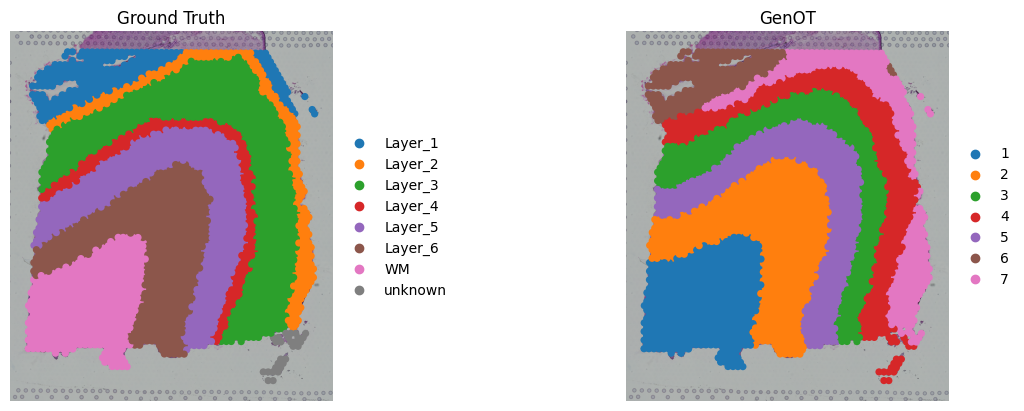

In [292]:
sc.pl.spatial(
    adata,
    color=['Ground Truth', 'domain'],
    title=['Ground Truth', 'GenOT'],
    ncols=2,
    frameon=False,
    spot_size=200
)